In [4]:
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import pytensor 
import pymc as pm
import arviz as az
import jax
import jax.numpy as jnp
import pyhf
pyhf.set_backend('jax')

from jax import grad, jit, vmap, value_and_grad, random
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

# Implementation of a gradient Op for HMC sampling

## Set up

### pyhf model

In [5]:
### Choose the right .json file
n = "DisplacedLeptons"

if n == "ttbar":
    with open("/Users/malinhorstmann/Documents/pyhf_pymc/PredictiveChecks/ttbar_ljets_xsec_inclusive_pruned.json") as serialized:
        spec = json.load(serialized)
    nBins = 37

if n == "DisplacedLeptons":
    with open("/Users/malinhorstmann/Documents/pyhf_pymc/PredictiveChecks/SRee_SRmm_Srem.json") as serialized:
        spec = json.load(serialized)
    nBins = 3


### Create pyhf model
workspace = pyhf.Workspace(spec)

model = workspace.model()

### Observations
obs = model.expected_data(model.config.suggested_init())

### Op

... preparing the `model.logpdf()` for Op implementation.

In [6]:
### model.expected_actualdata()
def processed_logpdf(p):
    ## return the logpdf as it is a single number
    dummy = model.logpdf(pars=p, data=obs)[0]

    return dummy

# print(processed_logpdf(model.config.suggested_init()))

### Processed logpdf function
ValueGrad_logpdf = jax.jit(jax.value_and_grad(processed_logpdf, argnums=list(range(1))))

In [7]:
class ValueGradOp(Op):
    # By default only show the first output, and "hide" the other ones
    default_output = 0

    def make_node(self, *inputs):
        inputs = [pt.as_tensor_variable(inp) for inp in inputs]
        # We now have one output for the function value, and one output for each gradient
        outputs = [pt.dscalar()] + [inp.type() for inp in inputs]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        result, grad_results = ValueGrad_logpdf(*inputs)
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)
        for i, grad_result in enumerate(grad_results, start=1):
            outputs[i][0] = np.asarray(grad_result, dtype=node.outputs[i].dtype)

    def grad(self, inputs, output_gradients):
        # The `Op` computes its own gradients, so we call it again.
        value = self(*inputs)
        # We hid the gradient outputs by setting `default_update=0`, but we
        # can retrieve them anytime by accessing the `Apply` node via `value.owner`
        gradients = value.owner.outputs[1:]

        # Make sure the user is not trying to take the gradient with respect to
        # the gradient outputs! That would require computing the second order
        # gradients
        assert all(
            isinstance(g.type, pytensor.gradient.DisconnectedType) for g in output_gradients[1:]
        )

        return [output_gradients[0] * grad for grad in gradients]

... testing the gradient output of `ValueGradOp()`:

In [8]:
test = ValueGradOp()

### 
with pm.Model():
    ## TensorVar input parameters
    nPars = len(model.config.par_names)
    pars = []
    pars.extend(pm.Gamma(f"dummy{idx}", alpha=20, beta=20) for idx in range(nPars))
    pars = pt.as_tensor_variable(pars)

### Print grads wrt to all parameters
x = test(pars)
pt.grad(x, pars).eval()


array([ 1.14330710e+03, -1.40815870e-02, -9.72699907e-01, -7.97934091e-01,
       -1.36009350e+00, -1.46624440e+00, -1.02429935e+00, -1.50342778e+00,
       -1.12416988e+00, -6.35415650e-01, -1.04289171e+00, -7.99479416e-01,
       -1.17757766e+00, -9.63958251e-01, -9.74392853e-01, -1.00680082e+00,
       -9.19329280e-01, -1.28963232e+00])

## Sampling

### Sampling with the ValueGrad Op

In [9]:
### Applying the Op
VG_logpdf = ValueGradOp()

### Specs
nPars = len(model.config.par_names)
N_prior = 500
N_posterior = 50

prior = "normal"

mu = 1
sigma = 0.1
alBet = 40

### Opening the pyMC model space
start_time = time.time()
with pm.Model() as basic_model:
    ## TensorVar input parameters
    pars = []
    if prior == "gamma":
        pars.extend(pm.Gamma(f"dummy{idx}", alpha=alBet, beta=alBet) for idx in range(nPars))
    if prior == "normal":
        pars.extend(pm.Normal(f"dummy{idx}", mu=mu, sigma=sigma) for idx in range(nPars))
    pars = pt.as_tensor_variable(pars)

    ## Model for the logpdf()
    main = pm.Normal("main", mu=VG_logpdf(pars), sigma=1)#, observed=obs)
    
    ## Sampling ...
    post_data = pm.sample(500, progressbar=False)
    prior_data = pm.sample_prior_predictive(N_prior)
    post_pred = pm.sample_posterior_predictive(post_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dummy0, dummy1, dummy2, dummy3, dummy4, dummy5, dummy6, dummy7, dummy8, dummy9, dummy10, dummy11, dummy12, dummy13, dummy14, dummy15, dummy16, dummy17, main]
Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 26 seconds.
Sampling: [dummy0, dummy1, dummy10, dummy11, dummy12, dummy13, dummy14, dummy15, dummy16, dummy17, dummy2, dummy3, dummy4, dummy5, dummy6, dummy7, dummy8, dummy9, main]


In [7]:
# az.plot_trace(post_data, var_names="main")
az.summary(post_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
dummy0,1.001,0.059,0.902,1.094,0.008,0.005,55.0,56.0,1.12
dummy1,0.990,0.100,0.759,1.143,0.007,0.005,218.0,114.0,1.04
dummy2,0.995,0.103,0.822,1.219,0.008,0.006,169.0,100.0,1.02
dummy3,1.003,0.111,0.770,1.155,0.009,0.006,190.0,72.0,1.05
dummy4,1.008,0.098,0.826,1.175,0.008,0.006,146.0,91.0,1.00
dummy5,0.996,0.101,0.788,1.178,0.008,0.006,152.0,70.0,1.07
dummy6,0.998,0.101,0.816,1.187,0.007,0.005,198.0,134.0,1.06
dummy7,1.004,0.103,0.818,1.203,0.008,0.006,169.0,54.0,1.04
dummy8,1.002,0.105,0.819,1.189,0.009,0.006,150.0,113.0,1.02
dummy9,1.008,0.097,0.792,1.172,0.007,0.005,224.0,155.0,1.03


array([[<AxesSubplot: title={'center': 'main'}>,
        <AxesSubplot: title={'center': 'main'}>]], dtype=object)

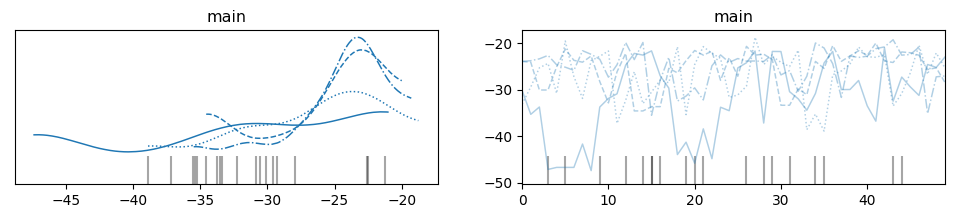

In [8]:
az.plot_trace(post_data, var_names="main")